In [ ]:
'''
import library 
'''
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!pip install -U opencv-contrib-python==3.4.2.17
import cv2

Requirement already up-to-date: opencv-contrib-python==3.4.2.17 in /usr/local/lib/python3.6/dist-packages (3.4.2.17)


In [ ]:
def interp2(v, xq, yq):

	if len(xq.shape) == 2 or len(yq.shape) == 2:
		dim_input = 2
		q_h = xq.shape[0]
		q_w = xq.shape[1]
		xq = xq.flatten()
		yq = yq.flatten()

	h = v.shape[0]
	w = v.shape[1]
	if xq.shape != yq.shape:
		raise 'query coordinates Xq Yq should have same shape'

	x_floor = np.floor(xq).astype(np.int32)
	y_floor = np.floor(yq).astype(np.int32)
	x_ceil = np.ceil(xq).astype(np.int32)
	y_ceil = np.ceil(yq).astype(np.int32)

	x_floor[x_floor < 0] = 0
	y_floor[y_floor < 0] = 0
	x_ceil[x_ceil < 0] = 0
	y_ceil[y_ceil < 0] = 0

	x_floor[x_floor >= w-1] = w-1
	y_floor[y_floor >= h-1] = h-1
	x_ceil[x_ceil >= w-1] = w-1
	y_ceil[y_ceil >= h-1] = h-1

	v1 = v[y_floor, x_floor]
	v2 = v[y_floor, x_ceil]
	v3 = v[y_ceil, x_floor]
	v4 = v[y_ceil, x_ceil]

	lh = yq - y_floor
	lw = xq - x_floor
	hh = 1 - lh
	hw = 1 - lw

	w1 = hh * hw
	w2 = hh * lw
	w3 = lh * hw
	w4 = lh * lw

	interp_val = v1 * w1 + w2 * v2 + w3 * v3 + w4 * v4

	if dim_input == 2:
		return interp_val.reshape(q_h, q_w)
	return interp_val

In [ ]:
'''
Function (modify)
'''
def compute_homography(p1, p2):	
  """
  compute the homography transform
  p1, p2: 4 x 2, 4 groups of corresponding points
  """	
  # IMPLEMENT HERE, hint: you may find np.linalg.svd useful

  # construct the A matrix in the same way in the slides
  row_num = 2 * p1.shape[0]
  A = np.zeros((row_num, 9))
  
  for i in range(0, p1.shape[0]):
    A[2 * i] = np.array([p2[i][0], p2[i][1], 1, 0, 0, 0, -p2[i][0]*p1[i][0], -p2[i][1]*p1[i][0],-p1[i][0]])
    A[2 * i + 1] = np.array([0, 0, 0, p2[i][0], p2[i][1], 1, -p2[i][0]*p1[i][1], -p2[i][1]*p1[i][1],-p1[i][1]])

  u, s, vh = np.linalg.svd(A, full_matrices=True, compute_uv=True)
  
  v = vh.T
  h = np.reshape(v[:, -1], (9, 1))

  H = np.reshape(h,(3,3))
  H = H / H[2][2]

  # use SVD to find the solution to Ax = 0

  # reorgnize the solution vector and normalize it to get homography matrix
  return H

In [ ]:
## Test ##
p1 = np.array([[366.6972,  106.9789,1],
  [439.9366,   84.4437,1],
  [374.5845,  331.2042,1],
  [428.6690,  326.6972,1]])

p2 = np.array([ [115.0000,  120.0000,1],
  [194.0000,  107.0000,1],
  [109.0000,  351.0000,1],
  [169.0000,  346.0000,1] ])
H = compute_homography(p1, p2)

assert np.allclose(H, np.array([[ 6.76097539e-01,  9.12020085e-02,  2.61445474e+02],
       [-1.57581282e-01,  9.59039559e-01,  5.18593524e+00],
       [-4.93549913e-04,  9.67378471e-05,  1.00000000e+00]]))

In [ ]:
def plot_corr(I1, I2, p1, p2):
  """
  utility function to plot correspondence between p1 in I1 and p2 in I2

  I1, I2: H * W, two input images of the same size
  p1, p2: N * 2, points on two images 
  """
  I = np.hstack((I1, I2))
  sy,sx = I1.shape[0:2]

  plt.figure()
  plt.imshow(I)
  plt.plot(p1[:, 0], p1[:, 1],'bo')
  plt.plot(sx + p2[:, 0], p2[:, 1],'rx')
  plt.plot(np.c_[p1[:, 0], sx + p2[:, 0]].T, np.c_[p1[:, 1],p2[:, 1]].T, 'g-')
  plt.show()

In [ ]:
'''
Function (modify)
'''
def match_features(f1,f2):
  """
  f1, f2: N * feature_size, two features to be matched
  """
  
  # IMPLEMENT HERE
  # hint: you may find cdist from scipy.spatial.distance, numpy.argsort useful
  dist = cdist(f1, f2) # return N1 * N2 matrix indicating distance of index i element in f1 to index j element in f2
  column_num = f2.shape[0]
  row_num = f1.shape[0]

  f2_id = np.arange(column_num)
  f2_id = np.reshape(f2_id, (1, column_num))

  f1_id = np.arange(row_num)
  f1_id = np.reshape(f1_id, (row_num, 1))

  # compute pairwise distance between f1 and f2
  # forward matching, find closet two matches in f2 to f1 and do a ratio test
  
  newdist = np.argsort(dist, axis=1)
  f1simi =[]
  f2simi =[]

  for i in range(row_num):
    if dist[i][newdist[i][0]] / dist[i][newdist[i][1]] < 0.7:
      f1simi.append((i, newdist[i][0]))
  match_fwd = np.asanyarray(f1simi)

  newdist2 = np.argsort(dist, axis=0)
  for i in range(column_num):
    if dist[newdist2[0][i]][i] / dist[newdist2[1][i]][i] < 0.7:
      f2simi.append((newdist2[0][i], i))
  match_bkwd = np.asanyarray(f2simi)
  A = set(map(tuple, match_fwd))
  B = set(map(tuple, match_bkwd))
  inter = A & B
  match = np.array(list(inter))  
  # backward matching, find closet two matches in f1 to f2 and do a ratio test
  # get the intersect of two matching as the final result, python set 
  
  return match, match_fwd, match_bkwd

In [ ]:
## Test ##
a = np.array([[2, 3],[5, 8],[4, 10]])
b = np.array([[10, 2],[2, 3],[5, 7],[1, -10]])
match, match_fwd, match_bkwd = match_features(a, b)
assert np.allclose(match, np.array([[0, 1],[1, 2]]))
assert np.allclose(match_fwd, np.array([[0, 1],[1, 2],[2, 2]]))
assert np.allclose(match_bkwd, np.array([[0, 1],[1, 2]]))

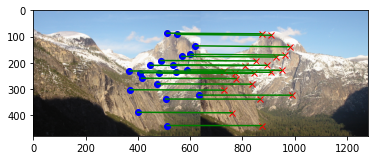

In [ ]:
"""
Script (do not modify)
"""

# load images in OpenCV BGR format
I1 = cv2.imread('yosemite1.jpg')
I2 = cv2.imread('yosemite2.jpg')

# create grayscale images
I1_gray = cv2.cvtColor(I1, cv2.COLOR_BGR2GRAY)
I2_gray = cv2.cvtColor(I2, cv2.COLOR_BGR2GRAY)

# convert images to RGB format for display
I1 = cv2.cvtColor(I1, cv2.COLOR_BGR2RGB)
I2 = cv2.cvtColor(I2, cv2.COLOR_BGR2RGB)

# compute SIFT features
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(I1_gray, None)
kp2, des2 = sift.detectAndCompute(I2_gray, None)

# match features
match, match_fwd, match_bkwd = match_features(des1, des2)

# get corresponding points p1, p2 
p1 = np.array([kp.pt for kp in kp1])[match[:, 0]]
p2 = np.array([kp.pt for kp in kp2])[match[:, 1]]

# plot first 20 matching points 
plot_corr(I1, I2, p1[:20], p2[:20])

In [ ]:
'''
Function (modify)
'''
def ransac_homography(p1, p2):
  """
  p1, p2: N * 2, correponding point coordinates
  """
  
  # IMPLEMENT HERE
  
  # decide how many loops to run and what the threshold is
  ep = 1e-1
  p2_exp = np.hstack((p2, np.ones((p2.shape[0], 1))))
  best_H = np.zeros((3,3))
  best = 0

  # RANSAC loop, inside in the loop
  iter = 142
  for i in range(iter):
    # 1. randomly pick n samples from p1 and p2 that is enough to fit a model(n=4 here)
    p4 = np.random.choice(p1.shape[0], 4, replace=False)
    pts = p1[p4,:]
    qts = p2[p4,:]

    # compute_homography
    H = compute_homography(pts, qts)
    transform = H@p2_exp.T
    transform /= transform[-1,:]# 3 x n
    # print(transform)
    p2_tran = (transform.T)[:,:2] # normalize last column

    #   2. fit the model and get a estimation
    #   3. count consensus(# of inliners that is close to the estimatiion within the threshold)
    distance = np.sqrt(np.sum((p2_tran - p1)**2, axis=1))
    fit_pts = len(distance[distance <= ep])
    
    #   4. update the best estimation if the current one is better 
    if fit_pts > best:
      best = fit_pts
      best_H = H

  return best_H

In [ ]:
## Test ##
p2 = np.random.randint(20, 200, size=(10, 2))
p2_ = np.hstack((p2, np.ones((10, 1)))).T
H = np.array([[ 6.76097539e-01,  9.12020085e-02,  2.61445474e+02],
       [-1.57581282e-01,  9.59039559e-01,  5.18593524e+00],
       [-4.93549913e-04,  9.67378471e-05,  1.00000000e+00]])
p1_ = H @ p2_
p1 = p1_ / p1_[-1, :]
p1 = p1[:2]
p1[:, -1] += 50
p1 = p1.T
assert np.allclose(H, ransac_homography(p1, p2))

H_hat 
[[ 2.00000000e+00 -4.85265293e-14  2.00000000e+00]
 [ 2.27900362e-15  2.00000000e+00  3.00000000e+00]
 [ 0.00000000e+00 -2.08296303e-15  1.00000000e+00]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


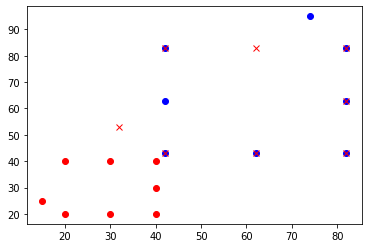

In [ ]:
p2= np.array([[20, 20],
              [20, 30],
              [20, 40],
              [40, 20],
              [40, 30],
              [40, 40],
              [30, 20],
              [30, 40]])

p2_ = np.hstack((p2, np.ones((p2.shape[0], 1)))).T

H = np.array([[2,  0,  2],
              [0,  2,  3],
              [0,  0,  1]])
p1_ = H @ p2_
p1 = p1_ / p1_[-1, :]
p1 = p1[:2]
p1[:, -1] += 12 # add noise
p1 = p1.T

p2[1, :] -=5 # add noise
plt.plot(p2[:, 0], p2[:, 1], 'ro')
plt.plot(p1[:, 0], p1[:, 1], 'bo')

H_hat = ransac_homography(p1, p2)
print("H_hat \n" + str(H_hat))
p2_ = np.hstack((p2, np.ones((p2.shape[0], 1)))).T
p1_hat_ = H_hat @ p2_
p1_hat = p1_hat_ / p1_hat_[-1, :]
p1_hat = p1_hat[:2]
p1_hat = p1_hat.T
plt.plot(p1_hat[:, 0], p1_hat[:, 1], 'rx')

In [ ]:
"""
Function (do not modify)
"""
def stitch(I1, I2, H):
    """
    utility function to stitch two images

    Input:

    I1: H1 x W1 x 3, target image
    I2: H2 x W2 x 3, source image
    H: homography matrix such that I1 = H @ I2

    Output:
    I_: stitching result
    """
    
    # map I2 to I1
    I1_x = I1.shape[1]
    I1_y = I1.shape[0]

    I2_x = I2.shape[1]
    I2_y = I2.shape[0]
    mesh1, mesh2 = np.meshgrid(range(I2_x), range(I2_y))
    m_r1 = np.ravel(mesh1)
    m_r2 = np.ravel(mesh2)
    I2_full_pos = np.vstack((np.vstack((m_r1, m_r2)), np.ones((1, len(m_r1)))))
    I2_I1 = H@ I2_full_pos

    I2_I1 = I2_I1 / I2_I1[2,:][None,:]

    max_arr = np.amax(I2_I1, axis=1)
    min_arr = np.amin(I2_I1, axis=1)

    I_x_start = min(0, min_arr[0])
    I_x_end = max(I1_x - 1 , max_arr[0])
    I_y_start = min(0, min_arr[1])
    I_y_end = max(I1_y - 1 , max_arr[1])

    # create new dimensions to accomodate points from I2
        # create images I_ for mapping
    I_ = np.zeros((int(np.ceil(I_y_end - I_y_start)) + 1,int(np.ceil(I_x_end - I_x_start)) + 1,3),dtype=int)
    x_offset = 0
    y_offset = 0
    # make sure the I2 pos in I1 is positive?
    if I_x_start < 0:
      x_offset = int(np.absolute(np.ceil(I_x_start)))
      I2_I1[0,:] += x_offset

    if I_y_start < 0:
      y_offset = int(np.absolute(np.ceil(I_y_start)))
      I2_I1[1,:] += y_offset

    H_inv = np.linalg.pinv(H)

    Ix_inI2, Iy_inI2 = np.meshgrid(range(I_.shape[1]), range(I_.shape[0]))
    Ix_r = np.ravel(Ix_inI2)
    Iy_r = np.ravel(Iy_inI2) - y_offset
    I_inI2 = np.vstack((np.vstack((Ix_r, Iy_r)), np.ones((1, len(Ix_r)))))

    # coordinate of I_ in I2 frame
    I_inI2_transformed = H_inv@ I_inI2

    #normalized the cooridnate
    I_inI2_transformed /= I_inI2_transformed[-1,:]

    Ix_inI2_t = np.reshape(I_inI2_transformed[0,:], (I_.shape[0], I_.shape[1]))
    Iy_inI2_t = np.reshape(I_inI2_transformed[1,:], (I_.shape[0], I_.shape[1]))
    
    I_I2 = np.zeros((int(np.ceil(I_y_end - I_y_start)) + 1,int(np.ceil(I_x_end - I_x_start)) + 1,3),dtype=int)

    for i in range(3):
      I_I2[:,:,i] = interp2(I2[:,:,i], Ix_inI2_t, Iy_inI2_t)

    I_I2[Ix_inI2_t < 0 ] = 0
    I_I2[Ix_inI2_t > I2.shape[1] - 1 ] = 0

    I_I2[Iy_inI2_t < 0 ] = 0
    I_I2[Iy_inI2_t > I2.shape[0] - 1 ] = 0
    
    I_[y_offset:y_offset + I1.shape[0], x_offset : x_offset + I1.shape[1],:] = I1[:,:,:]
    
    I_[np.where(I_ == 0) and np.where(I_I2 > 0)] = I_I2[np.where(I_ == 0) and np.where(I_I2 > 0)]
    
    I_[np.where(I_ > 0) and np.where(I_I2 > 0)] = I_I2[np.where(I_ > 0) and np.where(I_I2 > 0)] *0.5 + I_[np.where(I_ > 0) and np.where(I_I2 > 0)]*0.5
    
    return I_

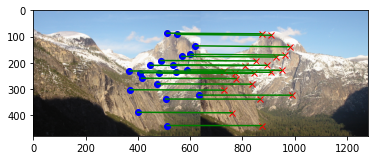

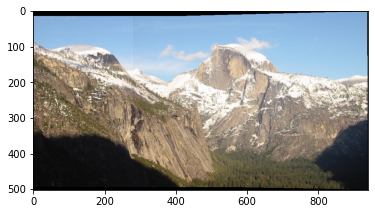

In [ ]:
"""
Script (do not modify)
"""

# load images in OpenCV BGR format
I1 = cv2.imread('yosemite1.jpg')
I2 = cv2.imread('yosemite2.jpg')

# create grayscale images
I1_gray = cv2.cvtColor(I1, cv2.COLOR_BGR2GRAY)
I2_gray = cv2.cvtColor(I2, cv2.COLOR_BGR2GRAY)

# convert images to RGB format for display
I1 = cv2.cvtColor(I1, cv2.COLOR_BGR2RGB)
I2 = cv2.cvtColor(I2, cv2.COLOR_BGR2RGB)

# compute SIFT features
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(I1_gray, None)
kp2, des2 = sift.detectAndCompute(I2_gray, None)

# match features
match, match_fwd, match_bkwd = match_features(des1, des2)

# get corresponding points p1, p2 
p1 = np.array([kp.pt for kp in kp1])[match[:, 0]]
p2 = np.array([kp.pt for kp in kp2])[match[:, 1]]

# plot first 20 matching points 
plot_corr(I1, I2, p1[:20], p2[:20])

# estimate homography transform with RANSAC

H = ransac_homography(p1, p2)

# stitch two images together and show the results
I = stitch(I1,I2,H)
plt.figure()
plt.imshow(I)
plt.show()